In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

# Define a class for adding Gaussian noise to the dataset
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Path to your dataset
dataset_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

# Image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the images to 64x64
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize the tensors
    AddGaussianNoise(0., 0.1)  # Add Gaussian noise with mean=0 and std=0.1
])

# Load the dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [2]:
# Defining the Generator

import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [3]:
# Defining the Discriminator 

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


In [4]:
# Initializing the models, loss functions and optimizers 

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize Generator and Discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

# Initialize BCELoss function
criterion = torch.nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=3e-4, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=3e-4, betas=(0.5, 0.999))


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import utils as vutils
import os

# Number of epochs to train for
num_epochs = 10000  # Adjust this to your needs

# Initialize Generator and Discriminator
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netG = Generator().to(device)
netD = Discriminator().to(device)

# Initialize BCELoss function
criterion = torch.nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Checkpoints directory
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

#     # Save model checkpoints at the end of each epoch
#     checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
#     torch.save({
#         'epoch': epoch,
#         'netG_state_dict': netG.state_dict(),
#         'netD_state_dict': netD.state_dict(),
#         'optimizerG_state_dict': optimizerG.state_dict(),
#         'optimizerD_state_dict': optimizerD.state_dict(),
#         'lossG': errG.item(),
#         'lossD': errD.item(),
#         'fixed_noise': fixed_noise,  # Save fixed_noise for consistent image generation
#     }, checkpoint_path)


Starting Training Loop...
[0/10000][0/13]	Loss_D: 1.3474	Loss_G: 2.4885	D(x): 0.4525	D(G(z)): 0.4097 / 0.0855
[1/10000][0/13]	Loss_D: 0.0544	Loss_G: 7.4068	D(x): 0.9842	D(G(z)): 0.0372 / 0.0007
[2/10000][0/13]	Loss_D: 0.0154	Loss_G: 8.5549	D(x): 0.9947	D(G(z)): 0.0099 / 0.0002
[3/10000][0/13]	Loss_D: 0.0150	Loss_G: 15.1717	D(x): 0.9859	D(G(z)): 0.0000 / 0.0000
[4/10000][0/13]	Loss_D: 0.0050	Loss_G: 12.1009	D(x): 0.9951	D(G(z)): 0.0000 / 0.0000
[5/10000][0/13]	Loss_D: 0.5974	Loss_G: 18.0374	D(x): 0.6559	D(G(z)): 0.0000 / 0.0000
[6/10000][0/13]	Loss_D: 0.0232	Loss_G: 11.6393	D(x): 0.9785	D(G(z)): 0.0000 / 0.0000
[7/10000][0/13]	Loss_D: 0.5129	Loss_G: 7.9103	D(x): 0.9392	D(G(z)): 0.3301 / 0.0005
[8/10000][0/13]	Loss_D: 1.9699	Loss_G: 9.8800	D(x): 0.9491	D(G(z)): 0.7513 / 0.0001
[9/10000][0/13]	Loss_D: 0.6140	Loss_G: 7.4959	D(x): 0.6221	D(G(z)): 0.0037 / 0.0007
[10/10000][0/13]	Loss_D: 0.3552	Loss_G: 4.8214	D(x): 0.8440	D(G(z)): 0.1546 / 0.0107
[11/10000][0/13]	Loss_D: 0.6291	Loss_G: 8.216

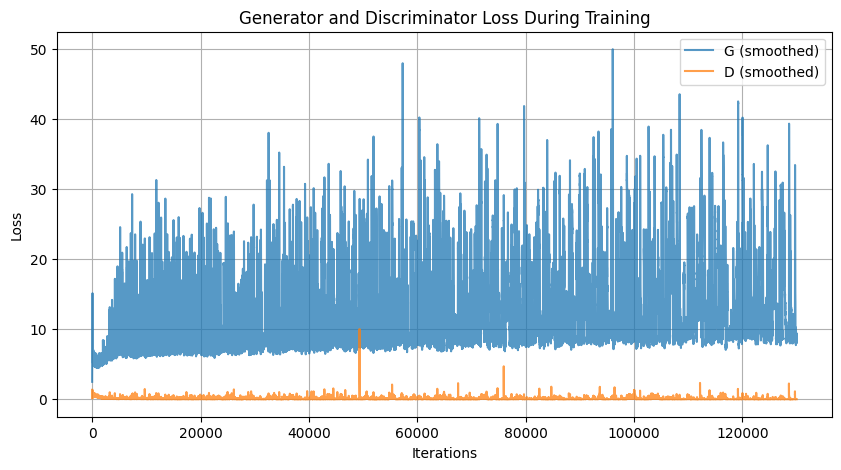

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.9):
    """Function to smooth curves for better visualization."""
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(smooth_curve(G_losses), label="G (smoothed)", alpha=0.75)
plt.plot(smooth_curve(D_losses), label="D (smoothed)", alpha=0.75)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)  # Add grid for easier reading
plt.savefig('training_loss_curves.png')  # Save the figure
plt.show()


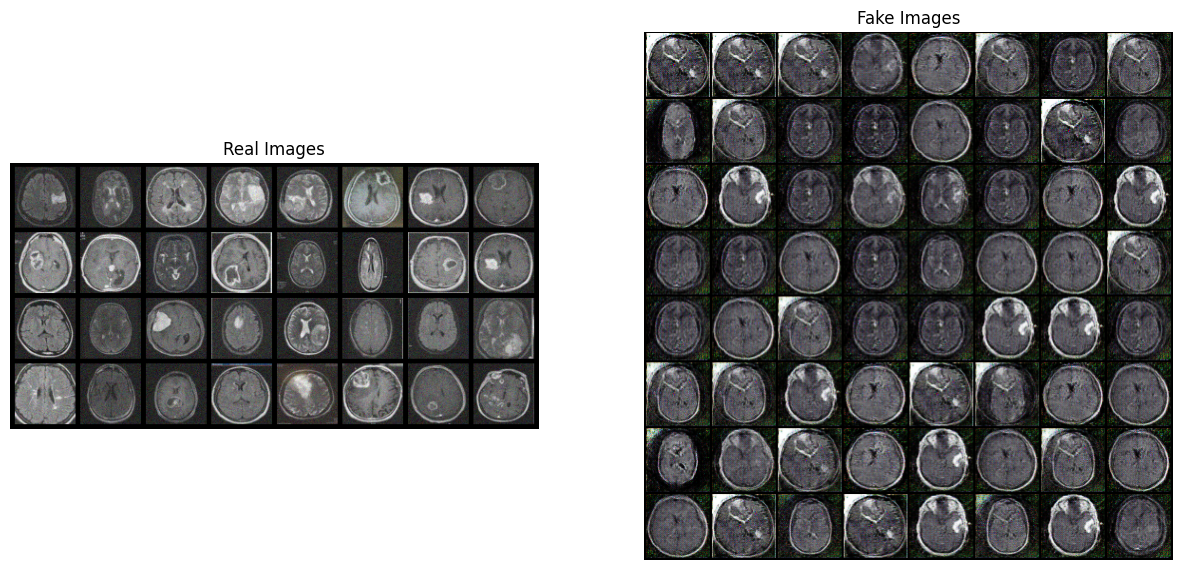

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils as vutils

# Ensure train_loader has been defined and loaded correctly
if not 'train_loader' in locals():
    raise ValueError("train_loader is not defined. Ensure your dataset is loaded properly.")

# Grab a batch of real images from the DataLoader
real_batch = next(iter(train_loader))

# Initialize figure
plt.figure(figsize=(15,15))

# Plot the real images
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
# Check if the device is CUDA and if so, convert back to CPU for plotting
if next(iter(real_batch))[0].is_cuda:
    real_images_for_plot = real_batch[0].cpu()
else:
    real_images_for_plot = real_batch[0]
plt.imshow(np.transpose(vutils.make_grid(real_images_for_plot[:64], padding=5, normalize=True),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
# Ensure there are generated images to display
if len(img_list) > 0:
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
else:
    print("No generated images to display yet.")

# Show and save the figure
plt.savefig('real_and_fake_images_comparison.png')  # Save the figure
plt.show()


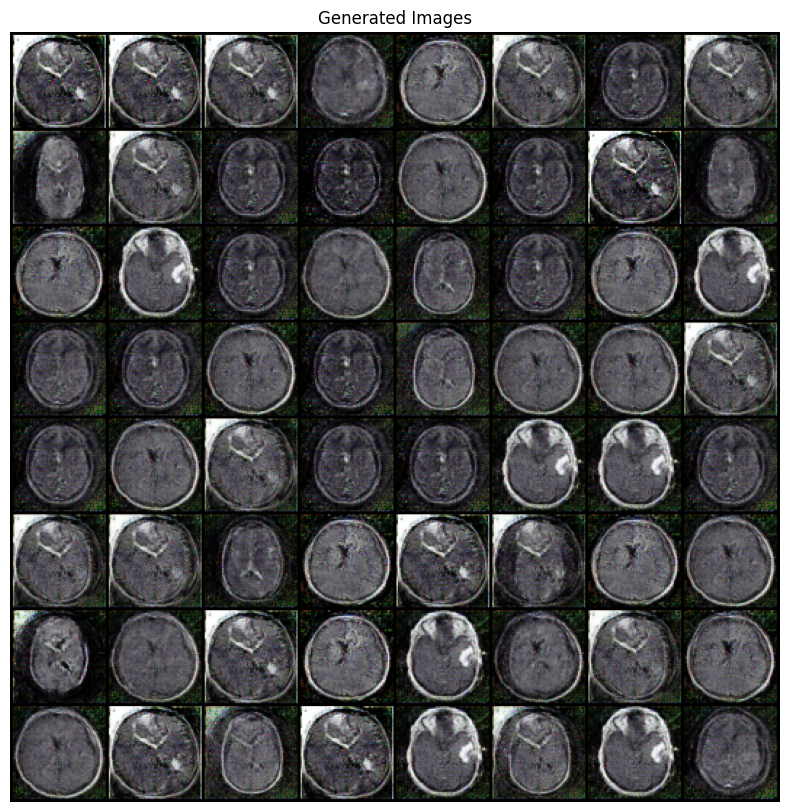

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Set the Generator to evaluation mode
netG.eval()

# Option to switch between fixed and new noise
use_fixed_noise = True  # Set to False if you want to generate new noise each time

# Generate a batch of images
with torch.no_grad():
    if use_fixed_noise:
        noise = fixed_noise  # Use the same noise each time for consistency
    else:
        # Generate new noise
        noise = torch.randn(fixed_noise.size(), device=device)  # Ensure new noise is the same size as fixed_noise
    
    generated_images = netG(noise).detach().cpu()

# Plotting the generated images
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True),(1,2,0)))
plt.show()


In [9]:
import torch
from torchvision import transforms, utils

# Ensure the DataLoader is defined
if 'train_loader' not in locals():
    raise ValueError("train_loader is not defined. Ensure your dataset is loaded properly.")

# Get a batch of real images from your DataLoader
real_batch = next(iter(train_loader))
real_images = real_batch[0].to(device)  # Assuming the first element is the images

# Resize and normalize the real images to match the generated ones if necessary
# Replace (64, 64) with the actual size of your generated images if different
resize_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to the same size as generated images
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize like the generated images
])
real_images = resize_transform(real_images)

# Note: If your real images are already normalized and resized, you can skip the above transformation


In [10]:
# Computue the Cross Entropy Loss 

import numpy as np

# Flatten and normalize the real and generated images
real_images_flat = real_images.view(real_images.size(0), -1).cpu().numpy()
generated_images_flat = generated_images.view(generated_images.size(0), -1).cpu().numpy()

# Compute histograms
real_hist = np.histogram(real_images_flat, bins=256, range=(0, 1))[0]
gen_hist = np.histogram(generated_images_flat, bins=256, range=(0, 1))[0]

# Normalize the histograms to create probability distributions
real_hist = real_hist / np.sum(real_hist)
gen_hist = gen_hist / np.sum(gen_hist)

# Use a small value to avoid division by zero during cross-entropy calculation
epsilon = 1e-10
real_hist = np.where(real_hist == 0, epsilon, real_hist)
gen_hist = np.where(gen_hist == 0, epsilon, gen_hist)

# Compute the cross-entropy
cross_entropy = -np.sum(real_hist * np.log(gen_hist))
print(f'Cross-Entropy between real and generated images: {cross_entropy}')


Cross-Entropy between real and generated images: 5.4170397778443
